In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import csv
import itertools
import pprint

In [2]:
class LSTM():
    
    def __init__(self):
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.LSTM(32))
      #  self.model.add(tf.keras.layers.LSTM(16,activation = 'relu'))
        self.model.add(tf.keras.layers.Dense(1))

        self.model.compile(optimizer='adam', loss='mae')

        
    def train(self,training_data,EOPCHS, EVALUATION_INTERVAL, validation_data):
        self.model.fit(training_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation_data, validation_steps=50)

    
    def predict(self,data):
        return self.model.predict(data)


In [13]:
def DataLoader(fname):
    df = pd.read_csv(fname)
    data = df['Price']
    data.index = df['Time']
    
    return data, df
       

def normalise_data(data):
    data = tf.keras.utils.normalize(data)
    return data[0]

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data  = []
    labels = []
    
    start_index += history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indicies = range(i-history_size, i)
        reshaped_data = np.reshape(dataset[indicies], (history_size,1))
        data.append(reshaped_data)
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

def create_time_steps(length):
    return list(range(-length,0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    plt.show()
    

def stationarise(df):
    diffed                  = (df['Price'] - df['Price'].shift(1))
    df['diffed']            = diffed.values
    diffed_and_logged       = np.log(df['Price']) - np.log(df['Price'].shift(1))
    df['diffed_and_logged'] = diffed_and_logged.values
    
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(df['diffed_and_logged'].values[1:], autolag="AIC")
    print('p-value: %f' % result[1])
    
    plt.plot(df['diffed_and_logged'])
    plt.show()
    
    return df
    

def preprocess(fname):
    data,df = DataLoader(fname)
    
    df = stationarise(df)
    df['diffed_and_logged'] = df['diffed_and_logged'].fillna(method = 'bfill')
    data_vals = df['diffed_and_logged'].values
    
    data_vals = normalise_data(data_vals)
    
    TRAIN_SPLIT = int(0.7*len(data_vals))
    univariate_past_history = 40
    univariate_future_target = 0

    x_train_uni, y_train_uni = univariate_data(data_vals, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
    x_val_uni, y_val_uni = univariate_data(data_vals, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)
    
    BATCH_SIZE = 256
    BUFFER_SIZE = 1000

    train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
    train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
    val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
    
    return [train_univariate, val_univariate]

p-value: 0.000000


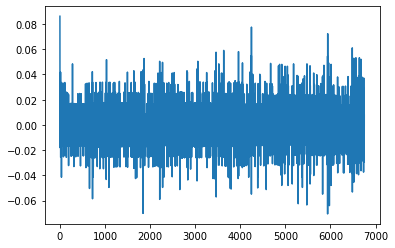

p-value: 0.000000


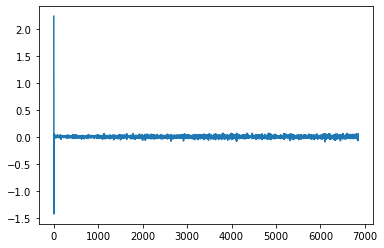

p-value: 0.000000


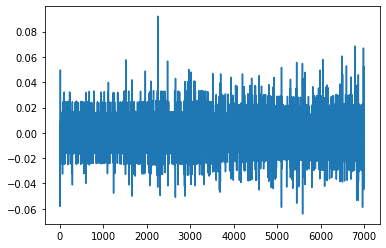

p-value: 0.000000


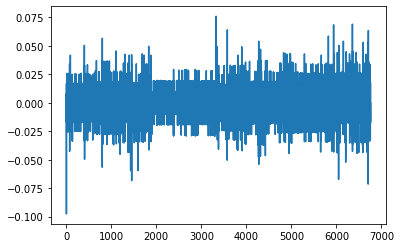

p-value: 0.000000


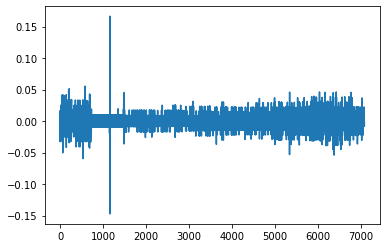

p-value: 0.000000


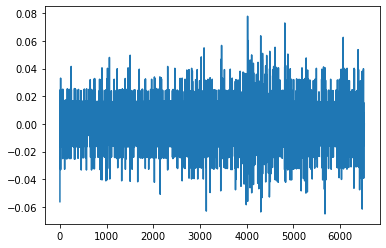

p-value: 0.000000


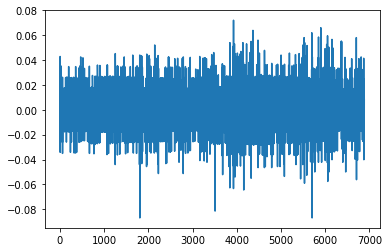

p-value: 0.000000


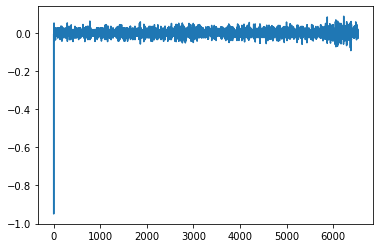

p-value: 0.000000


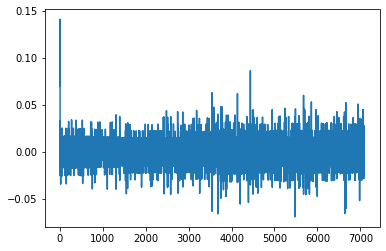

p-value: 0.000000


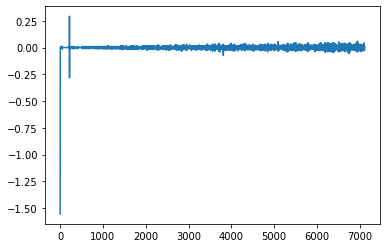

In [14]:
from os import listdir

def find_midprice_filenames( path_to_dir, suffix=".csv" , prefix ='midprice'):
    filenames = listdir(path_to_dir)
    return [ path_to_dir + filename for filename in filenames if (filename.endswith( suffix) and filename.startswith(prefix)) ]

fnames = find_midprice_filenames("../BSE/")


#returns list of [train_univariate, val_univariate]
results = list(map(preprocess,fnames))




In [12]:
EVALUATION_INTERVAL = 300
EPOCHS = 10
midprice_model = LSTM()

for result in results:
    train_univariate = result[0]
    val_univariate   = result[1]
    midprice_model.train(train_univariate, EPOCHS, EVALUATION_INTERVAL, val_univariate )


Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

300/300 [==============================] - 9s 29ms/step - loss: 0.0083 - val_loss: 0.0093
Epoch 2/10
300/300 [==============================] - 8s 26ms/step - loss: 0.0082 - val_loss: 0.0092
Epoch 3/10
300/300 [==============================] - 7s 25ms/step - loss: 0.0082 - val_loss: 0.0093
Epoch 4/10
300/300 [==============================] - 9s 30ms/step - loss: 0.0082 - val_loss: 0.0092
Epoch 5/10
300/300 [==============================] - 8s 26ms/step - loss: 0.0082 - val_loss: 0.0092
Epo

Epoch 5/10
300/300 [==============================] - 8s 26ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 6/10
300/300 [==============================] - 8s 27ms/step - loss: 0.0065 - val_loss: 0.0078
Epoch 7/10
300/300 [==============================] - 8s 25ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 8/10
300/300 [==============================] - 8s 27ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 9/10
300/300 [==============================] - 8s 25ms/step - loss: 0.0065 - val_loss: 0.0078
Epoch 10/10
300/300 [==============================] - 7s 25ms/step - loss: 0.0065 - val_loss: 0.0078
Epoch 1/10
300/300 [==============================] - 7s 25ms/step - loss: 0.0077 - val_loss: 0.0091
Epoch 2/10
300/300 [==============================] - 7s 25ms/step - loss: 0.0077 - val_loss: 0.0090
Epoch 3/10
300/300 [==============================] - 8s 25ms/step - loss: 0.0077 - val_loss: 0.0091
Epoch 4/10
300/300 [==============================] - 7s 25ms/step - loss: 0.0077 - val_lo

[0.00023937]


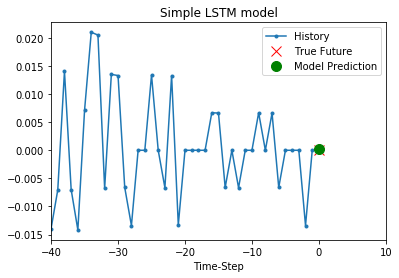

[-4.862657e-05]


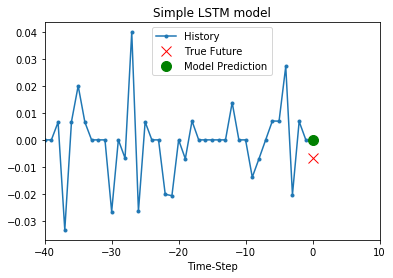

[0.0003525]


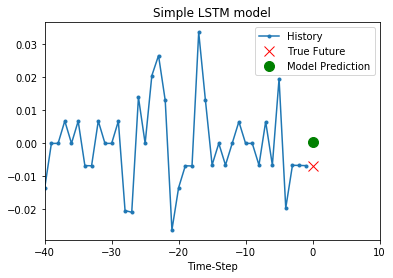

[0.00012637]


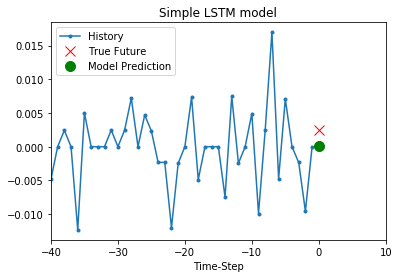

[0.00013358]


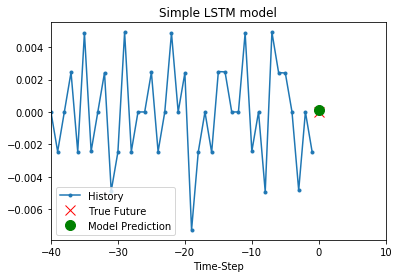

[-4.28203e-05]


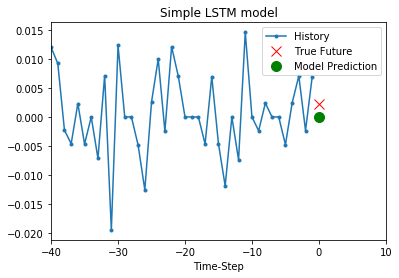

[1.4351892e-05]


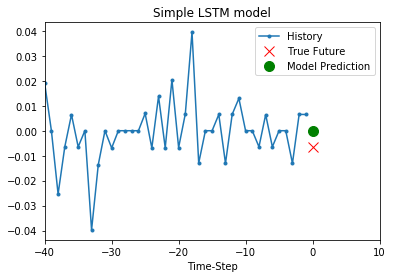

[0.00013353]


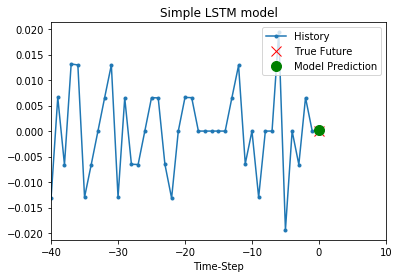

[0.00029527]


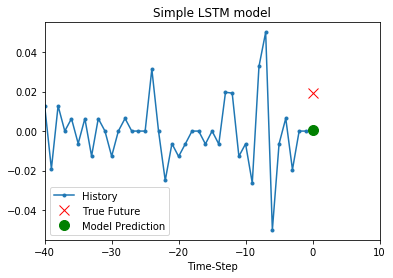

[0.00019986]


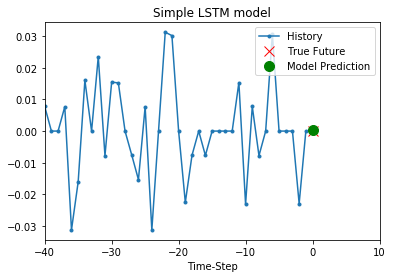

[-9.300974e-05]


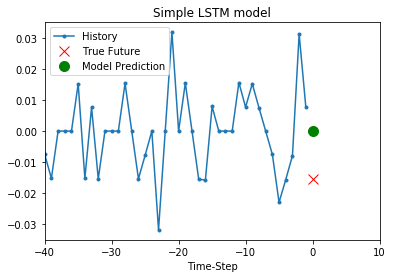

[0.00026023]


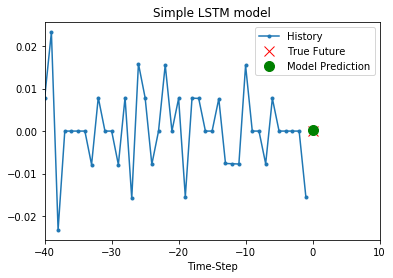

[-0.00039227]


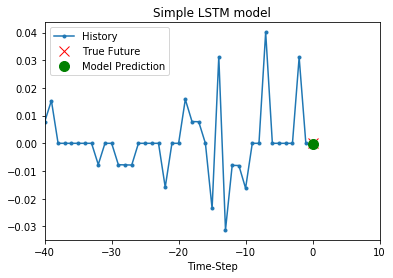

[0.00025118]


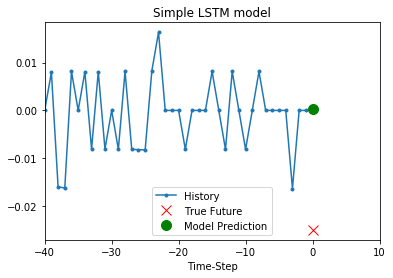

[0.00017171]


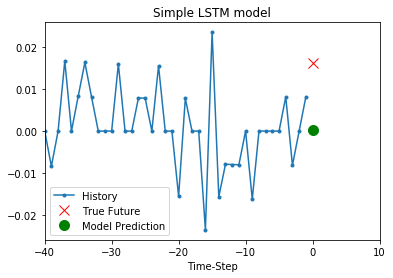

[0.00028478]


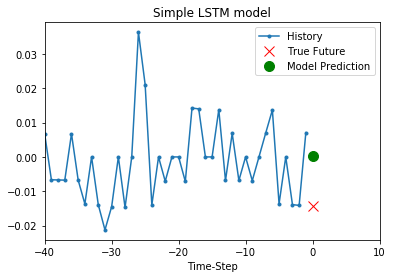

[0.00042673]


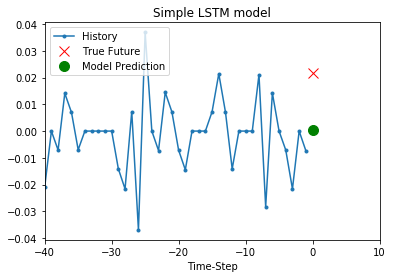

[-3.95201e-05]


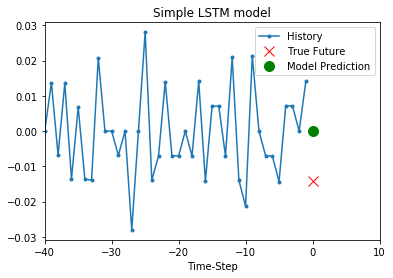

[0.00012082]


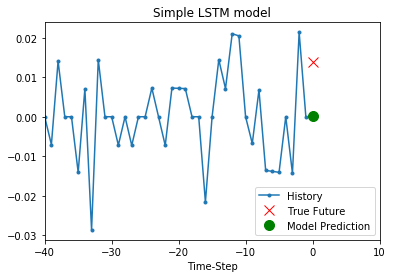

[-0.0001953]


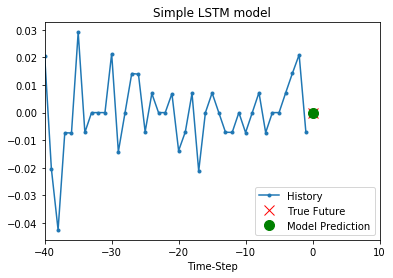

[0.00034846]


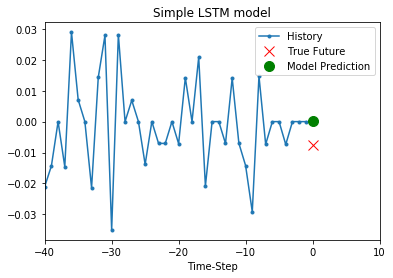

[0.00011225]


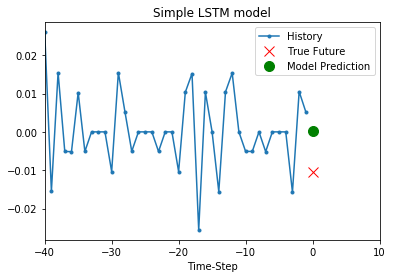

[0.0002231]


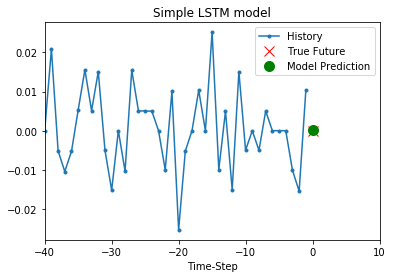

[7.284302e-05]


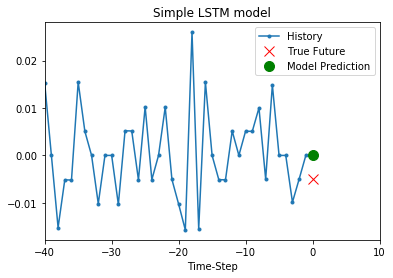

[0.00024794]


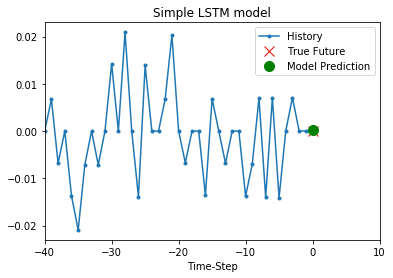

[0.00026947]


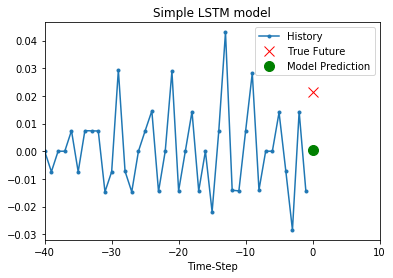

[0.0003483]


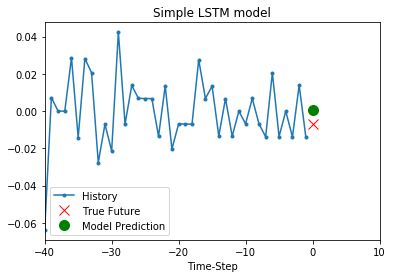

[4.8118476e-05]


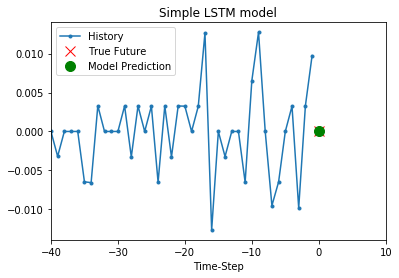

[0.00012854]


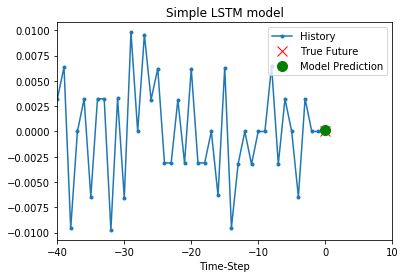

[5.5842946e-05]


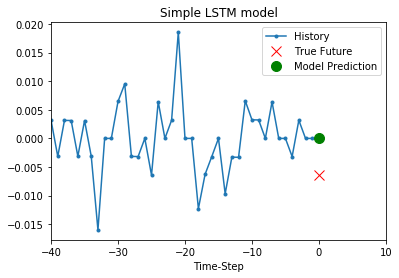

In [15]:
for result in results:
    val_univariate = result[1]
    for x, y in val_univariate.take(3):

        prediction = midprice_model.predict(x)[0]
        print (prediction)
        plot = show_plot([x[0].numpy(), y[0].numpy(),
                    prediction], 0, 'Simple LSTM model')

    